# Modelo de red neuronal convolucional base (50 capas)

Explicar lo que vamos a hacer en este notebook

### Preparación de los datos

In [1]:
# Importamos las paqueterías necesarias para el notebook
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# De ser posible utilizaremos GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
    """
    Función para cargar los datos de CIFAR-10
    """
    
    # Definimos el transform para normalizar los datos con pytorch
    # Los valores fueron obtenidos en el notebook de datos "data_extraction.ipynb"
    normalize = transforms.Normalize(  
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Definimos el transform para preporcesar los datos
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    # Obtener los datos del conjunto de prueba
    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # Cargamos una copia de los datos de entrenamiento
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Cargamos una copia extra de los datos de entrenamiento para dividirlo después en el conjunto de validación
    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Separamos los datos de entrenamiento y validación mediante índices
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Finalmente, definimos los conjuntos de entrenamiento y validación
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# Aplicamos la función para cargar los datos de CIFAR-10, los guardamos en el directorio actual
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)    
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Definición del modelo

Explicar en qué consiste el modelo y por qué lo elegí de 18 capas y como lo vamos a testear 

In [13]:
class ConvNet_50_capas(nn.Module):
    """
    Modelo de red neuronal convolucional de 50 capas para clasificar imágenes en 10 clases posibles
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        
        self.bloc1 = nn.Sequential(nn.Conv2d(64, 16, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 16, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 64, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU()
                                   )
        self.conv_down2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  #  feature map size = (16,16)
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()
                                       )
        
        self.bloc2 = nn.Sequential(nn.Conv2d(128, 32, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.Conv2d(32, 32, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.Conv2d(32, 128, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU()
                                  )
        
        self.conv_down3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  #  feature map size = (8,8)
                                        nn.BatchNorm2d(256),
                                        nn.ReLU())
        
        self.bloc3 = nn.Sequential(nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1),  
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),  
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   )
        
        self.conv_down4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  #  feature map size = (4,4)
                                        nn.BatchNorm2d(512),
                                        nn.ReLU())
        
        self.bloc4 = nn.Sequential(nn.Conv2d(512, 128, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 512, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU()
                                  )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512,10)


    def forward(self,x):
        out = self.conv1(x)
        for i in range(3):
            out = self.bloc1(out)
        out = self.conv_down2(out)
        for i in range(4):
            out = self.bloc2(out)
        out = self.conv_down3(out)
        for i in range(6):
            out = self.bloc3(out)
        out = self.conv_down4(out)
        for i in range(3):
            out = self.bloc4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = F.softmax(out, dim = 1)
        return out

### Entrenamiento

In [18]:
import gc
def entrenamiento():
    # variables para guardar los resultados
    accuracy_training_epochs = []
    accuracy_validation_epochs = []
    loss_epoch = []
    test_accuracy = []
    
    # hiperparámetros
    num_epochs = 90

    model = ConvNet_50_capas().to(device)

    optimizer = optim.SGD(
            params=model.parameters(),
            lr=0.1,
            momentum=0.9,
            weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=60, gamma=0.1)

    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)
    
    # entrenamiento
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, (images, labels) in enumerate(train_loader):

            # Mover a los tensores a GPU de ser posible
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass y descenso de gradiente estocástico
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ahorro de memoria
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        loss_epoch.append(loss.item())
        lr_scheduler.step() # Implementación de learning rate decay

        # Exactitud en el conjunto de validación
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            val_accuracy = correct/total
            accuracy_validation_epochs.append(val_accuracy)

        # Exactitud en el total del conjunto de entrenamiento
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            train_accuracy = correct/total
            accuracy_training_epochs.append(train_accuracy)

        # Exactitud en el conjunto de prueba
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            t_acc = correct/total
            test_accuracy.append(t_acc)



        print(f"Epoch [{epoch+1}/{num_epochs}], Training accuracy: {round(train_accuracy,3)}, Validation accuracy: {round(val_accuracy,3)}, loss = {round(loss_epoch[-1],3)}")
        print(f"Time spent on epoch {epoch+1}: {round((time.time()-start_time)/60,2)}min")
        
    return [model,
            accuracy_training_epochs,
            accuracy_validation_epochs,
            test_accuracy,
            loss_epoch]  # model, training accuracy, validation accuracy, test accuracy, loss

In [19]:
# repetimos 3 veces el experimento
model1, training1, validation1, test1, loss1 = entrenamiento()
model2, training2, validation2, test2, loss2 = entrenamiento()
model3, training3, validation3, test3, loss3 = entrenamiento()

Epoch [1/90], Training accuracy: 0.11, Validation accuracy: 0.109, loss = 2.322
Time spent on epoch 1: 4.1min
Epoch [2/90], Training accuracy: 0.173, Validation accuracy: 0.167, loss = 2.23
Time spent on epoch 2: 4.41min
Epoch [3/90], Training accuracy: 0.218, Validation accuracy: 0.219, loss = 2.312
Time spent on epoch 3: 5.0min
Epoch [4/90], Training accuracy: 0.222, Validation accuracy: 0.222, loss = 2.259
Time spent on epoch 4: 4.99min
Epoch [5/90], Training accuracy: 0.216, Validation accuracy: 0.206, loss = 2.43
Time spent on epoch 5: 5.29min
Epoch [6/90], Training accuracy: 0.21, Validation accuracy: 0.215, loss = 2.162
Time spent on epoch 6: 5.09min
Epoch [7/90], Training accuracy: 0.241, Validation accuracy: 0.243, loss = 2.321
Time spent on epoch 7: 5.34min
Epoch [8/90], Training accuracy: 0.196, Validation accuracy: 0.193, loss = 2.226
Time spent on epoch 8: 5.41min
Epoch [9/90], Training accuracy: 0.219, Validation accuracy: 0.219, loss = 2.281
Time spent on epoch 9: 5.48mi

Epoch [74/90], Training accuracy: 0.392, Validation accuracy: 0.381, loss = 1.975
Time spent on epoch 74: 5.4min
Epoch [75/90], Training accuracy: 0.391, Validation accuracy: 0.391, loss = 2.236
Time spent on epoch 75: 5.84min
Epoch [76/90], Training accuracy: 0.398, Validation accuracy: 0.391, loss = 2.106
Time spent on epoch 76: 5.71min
Epoch [77/90], Training accuracy: 0.395, Validation accuracy: 0.394, loss = 2.235
Time spent on epoch 77: 5.41min
Epoch [78/90], Training accuracy: 0.4, Validation accuracy: 0.386, loss = 2.319
Time spent on epoch 78: 5.47min
Epoch [79/90], Training accuracy: 0.402, Validation accuracy: 0.392, loss = 2.179
Time spent on epoch 79: 5.56min
Epoch [80/90], Training accuracy: 0.405, Validation accuracy: 0.389, loss = 2.127
Time spent on epoch 80: 5.42min
Epoch [81/90], Training accuracy: 0.408, Validation accuracy: 0.397, loss = 2.065
Time spent on epoch 81: 5.43min
Epoch [82/90], Training accuracy: 0.406, Validation accuracy: 0.396, loss = 2.076
Time spen

Epoch [57/90], Training accuracy: 0.409, Validation accuracy: 0.408, loss = 2.221
Time spent on epoch 57: 4.32min
Epoch [58/90], Training accuracy: 0.419, Validation accuracy: 0.41, loss = 2.107
Time spent on epoch 58: 4.34min
Epoch [59/90], Training accuracy: 0.311, Validation accuracy: 0.307, loss = 2.015
Time spent on epoch 59: 4.44min
Epoch [60/90], Training accuracy: 0.422, Validation accuracy: 0.421, loss = 2.014
Time spent on epoch 60: 4.35min
Epoch [61/90], Training accuracy: 0.469, Validation accuracy: 0.462, loss = 2.137
Time spent on epoch 61: 4.35min
Epoch [62/90], Training accuracy: 0.482, Validation accuracy: 0.474, loss = 1.972
Time spent on epoch 62: 4.37min
Epoch [63/90], Training accuracy: 0.486, Validation accuracy: 0.483, loss = 1.83
Time spent on epoch 63: 4.35min
Epoch [64/90], Training accuracy: 0.49, Validation accuracy: 0.479, loss = 2.0
Time spent on epoch 64: 4.37min
Epoch [65/90], Training accuracy: 0.496, Validation accuracy: 0.482, loss = 2.131
Time spent 

Epoch [40/90], Training accuracy: 0.305, Validation accuracy: 0.309, loss = 2.103
Time spent on epoch 40: 6.15min
Epoch [41/90], Training accuracy: 0.279, Validation accuracy: 0.281, loss = 2.392
Time spent on epoch 41: 6.24min
Epoch [42/90], Training accuracy: 0.306, Validation accuracy: 0.304, loss = 2.068
Time spent on epoch 42: 4.76min
Epoch [43/90], Training accuracy: 0.264, Validation accuracy: 0.265, loss = 2.26
Time spent on epoch 43: 4.9min
Epoch [44/90], Training accuracy: 0.315, Validation accuracy: 0.309, loss = 2.182
Time spent on epoch 44: 4.88min
Epoch [45/90], Training accuracy: 0.298, Validation accuracy: 0.296, loss = 2.228
Time spent on epoch 45: 4.71min
Epoch [46/90], Training accuracy: 0.26, Validation accuracy: 0.259, loss = 2.228
Time spent on epoch 46: 4.61min
Epoch [47/90], Training accuracy: 0.317, Validation accuracy: 0.307, loss = 2.175
Time spent on epoch 47: 4.47min
Epoch [48/90], Training accuracy: 0.314, Validation accuracy: 0.302, loss = 2.249
Time spen

In [27]:
# guardar uno de los modelos
torch.save(model1,"./model_ConvNet-50.pt")

### Resultados

In [20]:
import pandas as pd

C:\Users\kosoi\AppData\Local\Temp\ipykernel_3192\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [21]:
# Guardar en csv
results_dict1 = {"loss": loss1,
    'Train':training1,
     'Validation': validation1,
     "Test":test1}
results_dict2 = {"loss": loss2,
    'Train':training2,
     'Validation': validation2,
     "Test":test2}
results_dict3 = {"loss": loss3,
    'Train':training3,
     'Validation': validation3,
     "Test":test3}

pd.DataFrame(results_dict1).to_csv("./results/results_ConvNet50_1.csv",index=False)
pd.DataFrame(results_dict2).to_csv("./results/results_ConvNet50_2.csv",index=False)
pd.DataFrame(results_dict3).to_csv("./results/results_ConvNet50_3.csv",index=False)

In [22]:
results1 = pd.DataFrame(results_dict1)
results2 = pd.DataFrame(results_dict2)
results3 = pd.DataFrame(results_dict3)

In [24]:
# Accuracy 
accuracy = (results1["Test"].max() + results2["Test"].max() + results3["Test"].max())/3
print(accuracy)

0.47490000000000004


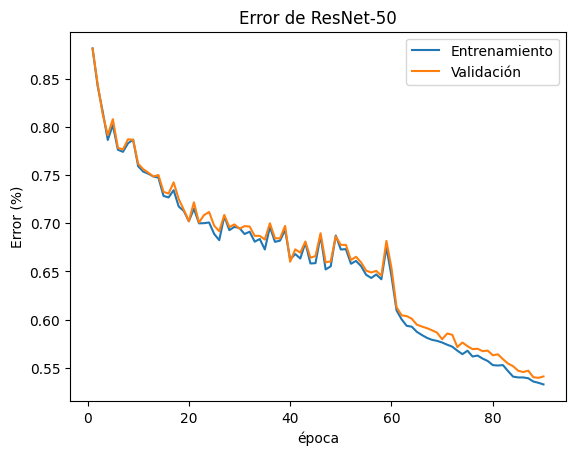

In [29]:
# graficar resultados
import matplotlib.pyplot as plt

x_axis = np.arange(90)+1
validation_err = 1- (np.array(validation1) + np.array(validation2) + np.array(validation3) )/3
train_err = 1- (np.array(training1)+np.array(training2)+np.array(training3))/3

plt.plot(x_axis, train_err)
plt.plot(x_axis, validation_err)
# plt.plot(x_axis, np.ones(90)*0.5, 'k--', linewidth = 0.5)
plt.title("Error de ResNet-50")
plt.ylabel('Error (%)')
plt.xlabel('época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()
plt.close()

### Ejemplo de predicción

Decir que vamos a poner a prueba el modelo

In [25]:
# cargar modelo


In [26]:
# poner 10 imágenes y de título su predicción.
